# Vanilla Policy Gradient
In this notebook the Deep Q-Learning Network approach is implemented in TensorFlow.

### Import dependencies

In [20]:
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm_notebook

from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random

from utils import plot_reward

### Setup environment

In [21]:
env = gym.make('CartPole-v0')


In [22]:
print(env.action_space, env.action_space.n)

Discrete(2) 2


In [23]:
print(env.observation_space.shape)

(4,)


### Helper functions

In [24]:
def get_action(action_probs, epsilon, env, stochastic=True):
    """
    Get action from actions space. With probability 1-epsilon,
    a random action is sampled, otherwise the action_probs are
    used to get an action. If stochastic, the actions are sampled
    according to the probablities of each action, otherwise the
    action with the highest probability is returned.
    """
    
    if np.random.rand()>epsilon:
        if stochastic:
            action = np.random.choice(list(range(len(action_probs))), p=action_probs)
        else:
            action = np.argmax(action_probs)
    else:
        action = env.action_space.sample()
    return action

def calc_discounted_rewards(r,gamma=0.9):
    """
    Calculate the discounted future rewards with 
    a gamma factor.
    """
    discounted_rewards = []
    
    for i in range(len(r)):
        tmp_rewards = []
        for j in range(len(r)-i):
            tmp_rewards.append(r[i+j]*(gamma**j))
        discounted_rewards.append(np.sum(tmp_rewards))
        
    return np.array(discounted_rewards)

### Memory for replay buffer

In [25]:
class Memory:
    
    def __init__(self, memory_size=None):
        self._memory = deque(maxlen=memory_size)
    
    def replay(self, n):
        return random.sample(self._memory, n)
        
    def memorize(self, elements):
        self._memory.append(elements)
        
    def __len__(self):
        return len(self._memory)

### Setup Q-network

In [26]:
def qforward(observation_space, action_space, shape=[24,24], lr=0.001):
    
    model = Sequential()
    
    model.add(Dense(shape[0], input_shape=observation_space, activation="relu"))
    for dim in shape[1:]:
        model.add(Dense(dim, activation="relu"))
    model.add(Dense(action_space, activation="linear"))
    
    model.compile(loss="mse", optimizer=Adam(lr=lr))

    return model

### Setup replay training

In [27]:
def model_replay(model, memory, batch_size, gamma):
    
    if len(memory)<batch_size:
        return
    
    batch = memory.replay(batch_size)
    
    state_list = []
    q_list = []
    for state, action, reward, state_next, terminal in batch:
        q_update = reward
        if not terminal:
            q_update = (reward + gamma * np.amax(model.predict(state_next)[0]))
        
        q_values = model.predict(state)
        q_values[0][action] = q_update
        q_list.append(q_values)
        state_list.append(state)
    
    state_list = np.concatenate(state_list)
    q_list = np.concatenate(q_list)
    model.fit(state_list, q_list, verbose=0)

### Training Scheme for DQN

In [28]:
def DQN(env, n_steps=10**4, epsilon_range=[0.99, 0.1], epsilon_decay=0.999,  render=False, max_memory=10**6, batch_size=20, gamma=0.95, lr=0.001):
    """
    DQN training scheme.
    
       args:
        env: OpenAI gym environment
        n_steps=10*4: number of training steps
        epsilon_range=[0.99, 0.1]: epsilon decay range
        render=False: option to render environment
        max_memory=10**6: memeory size of replay buffer
        batch_size=20: batch size for network training
        
    returns:
        memory: replay buffer
        dqn_model: trained dqn model
        total_rewards: list of total rewards during episode
    """
    

    obs_shape = env.observation_space.shape
    action_space = env.action_space.n
    print('obs shape:',obs_shape,'| action space:', action_space)
    
    dqn_model = qforward(obs_shape, action_space)
    
    memory = Memory(max_memory)
    
    epsilons = get_exp_epsilons(epsilon_range, epsilon_decay, n_steps)
    
    total_rewards = []
    tmp_reward = 0

    #game_done=True to reset env at the beginning
    game_done = True
    pbar = tqdm_notebook(range(n_steps))
    
    for i in pbar:
        if render:
            env.render()

        if game_done:
            obs = env.reset()
            obs = np.expand_dims(obs, axis=0)
            total_rewards.append(tmp_reward)
            pbar.set_description('reward: ' +str(tmp_reward))
            tmp_reward=0
            
            
        action_qs = dqn_model.predict(obs)
        action = get_action(np.squeeze(action_qs), epsilons[i], env, stochastic=False)
        next_obs, reward, game_done, info = env.step(action)
        
        if game_done:
            reward = -reward

        next_obs = np.expand_dims(next_obs, axis=0)
        
        memory.memorize([obs, action, reward, next_obs, game_done])  
        model_replay(dqn_model, memory, batch_size, gamma)
        
        obs = next_obs
        tmp_reward += reward

    env.close()
    return memory, dqn_model, total_rewards

### Train the Q-network

In [13]:
memory, model, total_rewards = DQN(env,
                                   render=False,
                                   n_steps=10000,
                                   lr=0.001,
                                   epsilon_range=[1,0.1],
                                   epsilon_decay=0.999,
                                   batch_size=20)

obs shape: (4,) | action space: 2


### Plot rewards

/Users/leandro/git/reproduce-rl/env/lib/python3.7/site-packages/pandas/core/window.py:1833: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


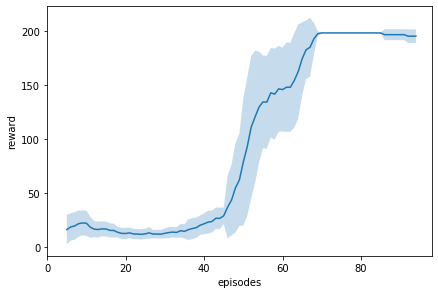

In [14]:
plot_reward(total_rewards, window=10)